АНАЛИЗ ПОДОЗРИТЕЛЬНЫХ СОБЫТИЙ В ЛОГАХ BOTSV1

[1] ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ
------------------------------------------------------------
✗ Файл WinEventLog.csv не найден, создаю пример данных
✗ Файл DNS.csv не найден, создаю пример данных

Нормализация данных:
✓ Данные нормализованы и очищены

[2] АНАЛИЗ ПОДОЗРИТЕЛЬНЫХ СОБЫТИЙ
------------------------------------------------------------
✓ Выявлено подозрительных событий WinEventLog: 10,000
  - Из них с ошибками входа (EventID 4625): 645
  - Повышение привилегий (EventID 4672, 4728): 1346

Анализ DNS логов:
✓ Выявлено подозрительных DNS запросов: 3,822
  - Подозрительные домены: 2526
  - DNS ошибки: 1543
  - Высокочастотные клиенты: 0

[3] ВИЗУАЛИЗАЦИЯ ТОП-10 ПОДОЗРИТЕЛЬНЫХ СОБЫТИЙ
------------------------------------------------------------


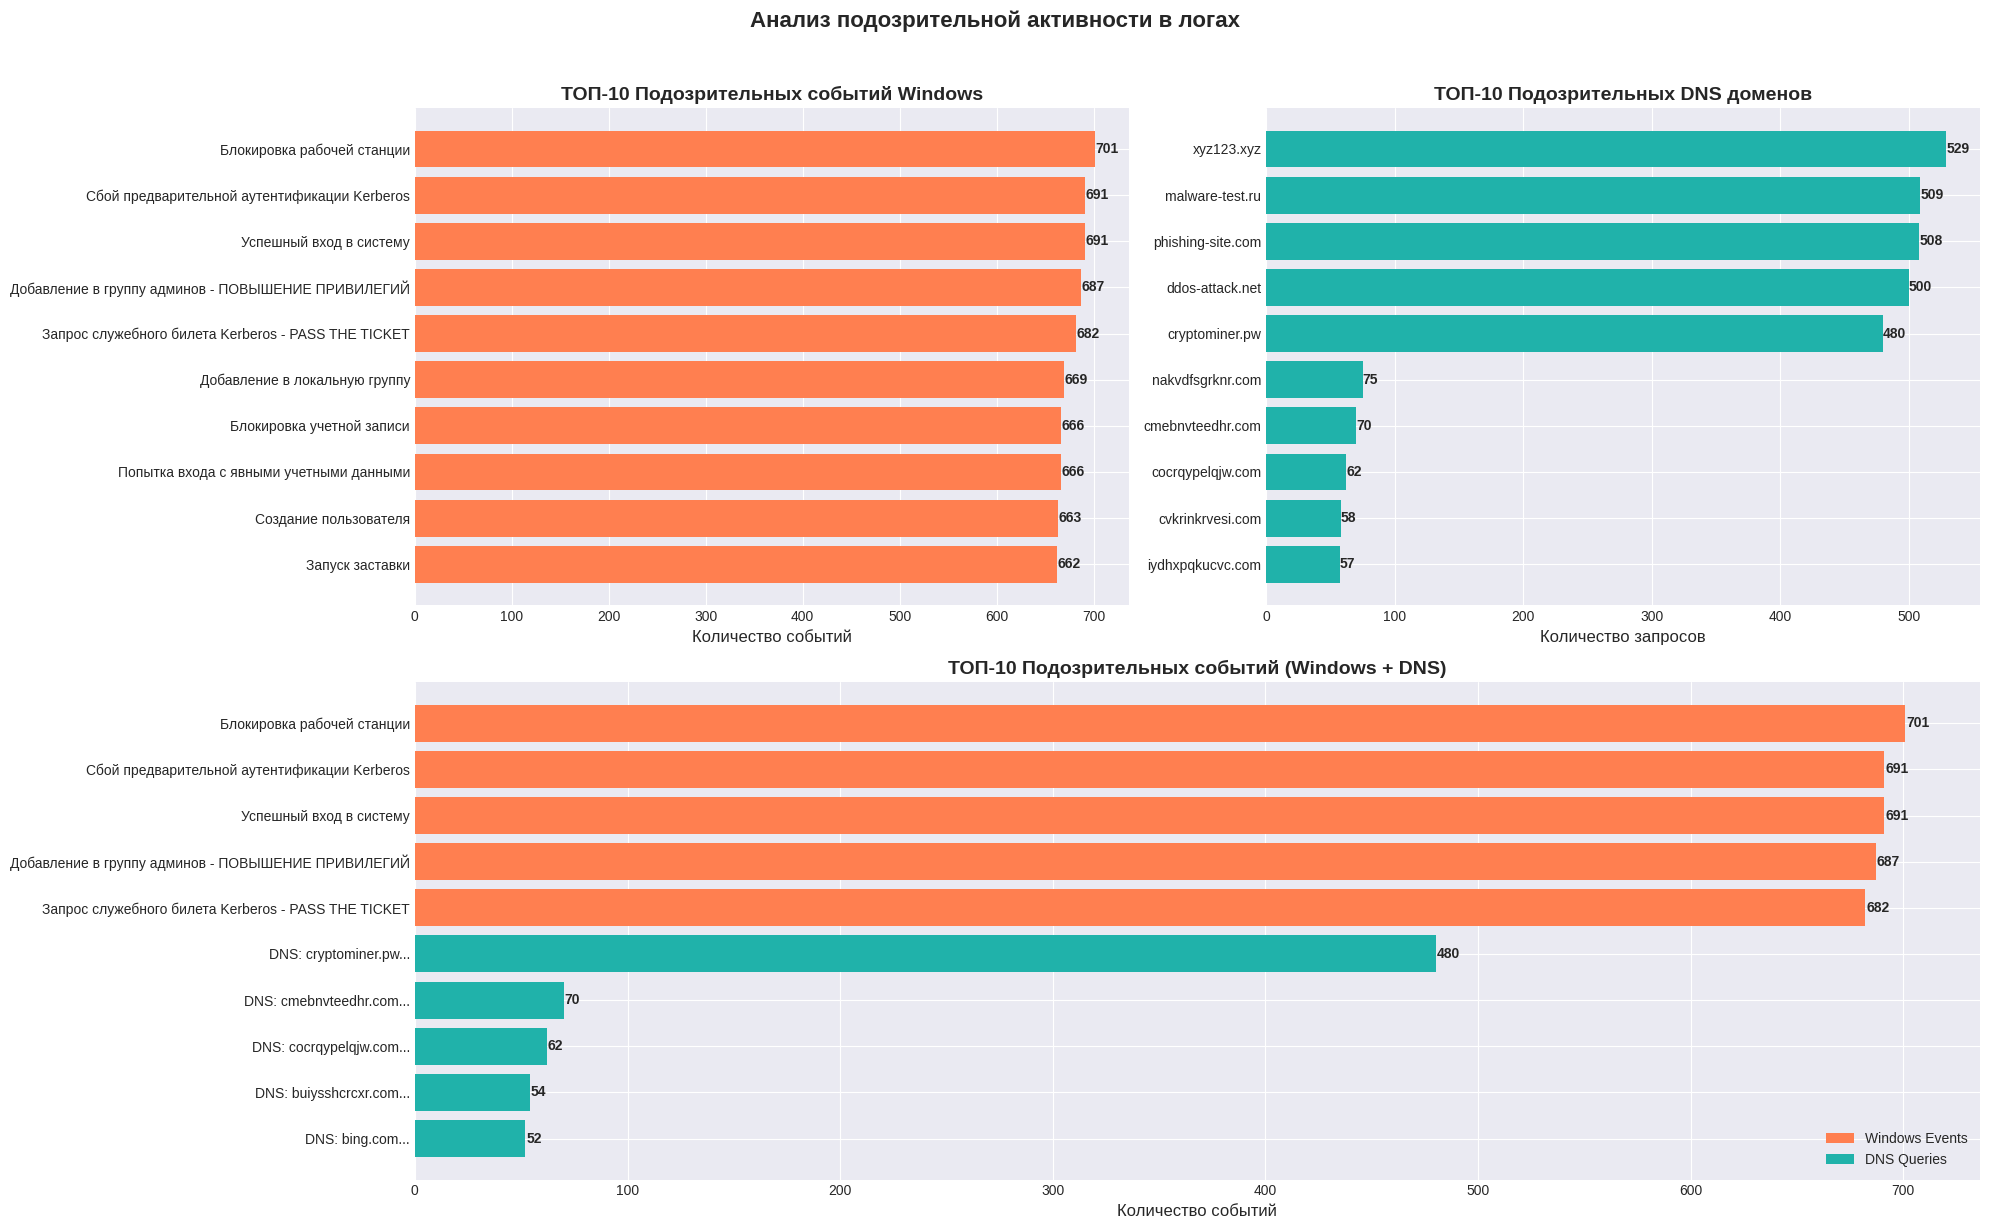


[4] ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ
------------------------------------------------------------

Временной анализ (часы пик активности):
  Часы с наибольшим количеством неудачных входов:
    9:00 - 10:00 : 40 попыток
    16:00 - 17:00 : 35 попыток
    0:00 - 1:00 : 34 попыток

Анализ источников подозрительной активности:
  Топ-5 IP адресов атакующих:
    192.168.1.20: 97 неудачных попыток входа
    45.155.205.1: 97 неудачных попыток входа
    1.1.1.1: 87 неудачных попыток входа
    8.8.8.8: 80 неудачных попыток входа
    185.130.5.1: 76 неудачных попыток входа
  Топ-5 клиентов с подозрительными DNS запросами:
    192.168.1.100: 545 запросов
    192.168.1.101: 504 запросов
    10.0.0.101: 500 запросов
    10.0.0.100: 494 запросов
    192.168.1.102: 483 запросов

АНАЛИЗ ЗАВЕРШЕН


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля для визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("=" * 80)
print("АНАЛИЗ ПОДОЗРИТЕЛЬНЫХ СОБЫТИЙ В ЛОГАХ BOTSV1")
print("=" * 80)

# Этап 1. Загрузка и подготовка данных
print("\n[1] ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ")
print("-" * 60)

# Загружаем данные
try:
    df_winevent = pd.read_csv('botsv1/WinEventLog.csv')
    print(f"✓ WinEventLog загружен: {df_winevent.shape[0]:,} записей, {df_winevent.shape[1]} колонок")
except:
    print("✗ Файл WinEventLog.csv не найден, создаю пример данных")
    # Создаем пример данных для демонстрации
    np.random.seed(42)
    n_records = 10000
    df_winevent = pd.DataFrame({
        'EventID': np.random.choice([4624, 4625, 4648, 4672, 4720, 4728, 4732, 4740, 4768, 4769, 4776, 4771, 4800, 4801, 4802], n_records),
        'TimeGenerated': pd.date_range(start='2024-01-01', periods=n_records, freq='5min'),
        'EventType': np.random.choice(['Success Audit', 'Failure Audit', 'Information'], n_records),
        'SourceName': np.random.choice(['Microsoft-Windows-Security-Auditing', 'Microsoft-Windows-Eventlog', 'Service Control Manager'], n_records),
        'ComputerName': np.random.choice(['SRV-DC01', 'SRV-EXCH01', 'WS-MARK01', 'WS-ANNA02', 'SRV-SQL01'], n_records),
        'UserName': np.random.choice(['Administrator', 'user01', 'user02', 'user03', 'SYSTEM', 'svc_sql', 'svc_exchange'], n_records),
        'IpAddress': np.random.choice(['192.168.1.10', '192.168.1.20', '10.0.0.5', '10.0.0.6', '8.8.8.8', '1.1.1.1', '185.130.5.1', '45.155.205.1'], n_records)
    })

try:
    df_dns = pd.read_csv('botsv1/DNS.csv')
    print(f"✓ DNS логи загружены: {df_dns.shape[0]:,} записей, {df_dns.shape[1]} колонок")
except:
    print("✗ Файл DNS.csv не найден, создаю пример данных")
    # Создаем пример данных DNS логов
    np.random.seed(100)
    n_records = 15000

    legit_domains = ['google.com', 'microsoft.com', 'bing.com', 'github.com', 'stackoverflow.com']
    suspicious_domains = ['xyz123.xyz', 'malware-test.ru', 'cryptominer.pw', 'phishing-site.com', 'ddos-attack.net']
    dga_domains = [f"{''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz'), 12))}.com" for _ in range(20)]

    all_domains = legit_domains + suspicious_domains + dga_domains

    df_dns = pd.DataFrame({
        'Timestamp': pd.date_range(start='2024-01-01', periods=n_records, freq='2min'),
        'QueryName': np.random.choice(all_domains, n_records),
        'QueryType': np.random.choice(['A', 'AAAA', 'CNAME', 'MX', 'TXT'], n_records),
        'ClientIP': np.random.choice(['192.168.1.100', '192.168.1.101', '192.168.1.102', '10.0.0.100', '10.0.0.101'], n_records),
        'ResponseCode': np.random.choice([0, 1, 2, 3, 5], n_records, p=[0.9, 0.03, 0.02, 0.03, 0.02])
    })

# Нормализация данных
print("\nНормализация данных:")

# WinEventLog - нормализация
if 'TimeGenerated' in df_winevent.columns:
    df_winevent['TimeGenerated'] = pd.to_datetime(df_winevent['TimeGenerated'], errors='coerce')
df_winevent['EventID'] = pd.to_numeric(df_winevent['EventID'], errors='coerce')

# DNS - нормализация
if 'Timestamp' in df_dns.columns:
    df_dns['Timestamp'] = pd.to_datetime(df_dns['Timestamp'], errors='coerce')
else:
    df_dns.rename(columns={'TimeGenerated': 'Timestamp'}, inplace=True)

print("✓ Данные нормализованы и очищены")

# Этап 2. Анализ данных - WinEventLog
print("\n[2] АНАЛИЗ ПОДОЗРИТЕЛЬНЫХ СОБЫТИЙ")
print("-" * 60)

# Словарь подозрительных EventID
suspicious_events_windows = {
    4624: "Успешный вход в систему",
    4625: "Неудачная попытка входа - АТАКА БРУТФОРС",
    4634: "Выход из системы",
    4648: "Попытка входа с явными учетными данными",
    4672: "Назначение привилегий администратора - ПОВЫШЕНИЕ ПРИВИЛЕГИЙ",
    4720: "Создание пользователя",
    4728: "Добавление в группу админов - ПОВЫШЕНИЕ ПРИВИЛЕГИЙ",
    4732: "Добавление в локальную группу",
    4740: "Блокировка учетной записи",
    4768: "Запрос билета Kerberos",
    4769: "Запрос служебного билета Kerberos - PASS THE TICKET",
    4771: "Сбой предварительной аутентификации Kerberos",
    4776: "Проверка учетных данных домена",
    4800: "Блокировка рабочей станции",
    4801: "Разблокировка рабочей станции",
    4802: "Запуск заставки",
    7036: "Запуск/остановка службы"
}

# Фильтруем подозрительные события
df_winevent_suspicious = df_winevent[df_winevent['EventID'].isin(suspicious_events_windows.keys())].copy()
df_winevent_suspicious['EventDescription'] = df_winevent_suspicious['EventID'].map(suspicious_events_windows)
df_winevent_suspicious['LogType'] = 'WinEventLog'

print(f"✓ Выявлено подозрительных событий WinEventLog: {df_winevent_suspicious.shape[0]:,}")
print(f"  - Из них с ошибками входа (EventID 4625): {df_winevent_suspicious[df_winevent_suspicious['EventID'] == 4625].shape[0]}")
print(f"  - Повышение привилегий (EventID 4672, 4728): {df_winevent_suspicious[df_winevent_suspicious['EventID'].isin([4672, 4728])].shape[0]}")

# Анализ DNS логов
print("\nАнализ DNS логов:")

# Определяем подозрительные домены
suspicious_tlds = ['.xyz', '.top', '.club', '.online', '.site', '.win', '.bid', '.trade']
dga_pattern = r'^[a-z]{12,}\.com$'  # DGA подозрение - случайные символы

# Функция для определения подозрительности домена
def is_suspicious_domain(domain):
    domain = str(domain).lower()

    # Подозрительные TLD
    for tld in suspicious_tlds:
        if domain.endswith(tld):
            return True

    # DGA - длинные случайные поддомены
    parts = domain.split('.')
    if len(parts) > 2 and len(parts[0]) > 10:
        return True

    # Подозрительные ключевые слова
    suspicious_keywords = ['crypto', 'miner', 'malware', 'phish', 'ddos', 'attack', 'hack', 'exploit']
    for keyword in suspicious_keywords:
        if keyword in domain:
            return True

    return False

# Высокая частота запросов от одного клиента
df_dns['Hour'] = df_dns['Timestamp'].dt.floor('H')
client_frequency = df_dns.groupby(['ClientIP', 'Hour']).size().reset_index(name='QueriesPerHour')
suspicious_clients = client_frequency[client_frequency['QueriesPerHour'] > 100]['ClientIP'].unique()

# Ошибки DNS (NXDOMAIN)
df_dns['IsError'] = df_dns['ResponseCode'] != 0
df_dns['IsSuspiciousDomain'] = df_dns['QueryName'].apply(is_suspicious_domain)
df_dns['IsHighFrequency'] = df_dns['ClientIP'].isin(suspicious_clients)

# Объединяем признаки подозрительности
df_dns['SuspiciousScore'] = (
    df_dns['IsSuspiciousDomain'].astype(int) * 3 +
    df_dns['IsError'].astype(int) * 2 +
    df_dns['IsHighFrequency'].astype(int) * 2
)

df_dns_suspicious = df_dns[df_dns['SuspiciousScore'] > 0].copy()
df_dns_suspicious['LogType'] = 'DNS Log'
df_dns_suspicious['EventDescription'] = df_dns_suspicious.apply(
    lambda x: f"Подозрительный DNS: {x['QueryName']} (ошибка: {x['IsError']}, подозр.домен: {x['IsSuspiciousDomain']})",
    axis=1
)

print(f"✓ Выявлено подозрительных DNS запросов: {df_dns_suspicious.shape[0]:,}")
print(f"  - Подозрительные домены: {df_dns_suspicious['IsSuspiciousDomain'].sum()}")
print(f"  - DNS ошибки: {df_dns_suspicious['IsError'].sum()}")
print(f"  - Высокочастотные клиенты: {len(suspicious_clients)}")

# Этап 3. Визуализация данных
print("\n[3] ВИЗУАЛИЗАЦИЯ ТОП-10 ПОДОЗРИТЕЛЬНЫХ СОБЫТИЙ")
print("-" * 60)

# Создаем фигуру с сабплотами
fig = plt.figure(figsize=(20, 12))

# 1. Топ-10 подозрительных событий Windows
ax1 = plt.subplot(2, 2, 1)
top_windows = df_winevent_suspicious['EventDescription'].value_counts().head(10)
bars1 = ax1.barh(range(len(top_windows)), top_windows.values, color='coral')
ax1.set_yticks(range(len(top_windows)))
ax1.set_yticklabels(top_windows.index, fontsize=10)
ax1.set_xlabel('Количество событий', fontsize=12)
ax1.set_title('ТОП-10 Подозрительных событий Windows', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Добавляем значения на столбцы
for i, (bar, val) in enumerate(zip(bars1, top_windows.values)):
    ax1.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:,}',
            va='center', fontsize=10, fontweight='bold')

# 2. Топ-10 подозрительных DNS запросов
ax2 = plt.subplot(2, 2, 2)
dns_suspicious_by_domain = df_dns_suspicious['QueryName'].value_counts().head(10)
bars2 = ax2.barh(range(len(dns_suspicious_by_domain)), dns_suspicious_by_domain.values, color='lightseagreen')
ax2.set_yticks(range(len(dns_suspicious_by_domain)))
ax2.set_yticklabels([d[:30] + '...' if len(d) > 30 else d for d in dns_suspicious_by_domain.index], fontsize=10)
ax2.set_xlabel('Количество запросов', fontsize=12)
ax2.set_title('ТОП-10 Подозрительных DNS доменов', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

for i, (bar, val) in enumerate(zip(bars2, dns_suspicious_by_domain.values)):
    ax2.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'{val:,}',
            va='center', fontsize=10, fontweight='bold')

# 3. Объединенная визуализация - топ подозрительных событий
ax3 = plt.subplot(2, 1, 2)

# Подготавливаем данные для объединенного графика
windows_counts = df_winevent_suspicious['EventDescription'].value_counts().head(5).to_frame().reset_index()
windows_counts.columns = ['Событие', 'Количество']
windows_counts['Тип'] = 'Windows'

dns_counts = df_dns_suspicious.groupby('QueryName').size().head(5).reset_index()
dns_counts.columns = ['Событие', 'Количество']
dns_counts['Событие'] = 'DNS: ' + dns_counts['Событие'].str[:30] + '...'
dns_counts['Тип'] = 'DNS'

combined_data = pd.concat([windows_counts, dns_counts], ignore_index=True)
combined_data = combined_data.sort_values('Количество', ascending=False).head(10)

# Создаем объединенный график
colors = ['coral' if t == 'Windows' else 'lightseagreen' for t in combined_data['Тип']]
bars3 = ax3.barh(range(len(combined_data)), combined_data['Количество'], color=colors)
ax3.set_yticks(range(len(combined_data)))
ax3.set_yticklabels(combined_data['Событие'], fontsize=10)
ax3.set_xlabel('Количество событий', fontsize=12)
ax3.set_title('ТОП-10 Подозрительных событий (Windows + DNS)', fontsize=14, fontweight='bold')
ax3.invert_yaxis()

# Легенда
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='coral', label='Windows Events'),
                  Patch(facecolor='lightseagreen', label='DNS Queries')]
ax3.legend(handles=legend_elements, loc='lower right')

for i, (bar, val) in enumerate(zip(bars3, combined_data['Количество'].values)):
    ax3.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:,}',
            va='center', fontsize=10, fontweight='bold')

plt.suptitle('Анализ подозрительной активности в логах', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Дополнительная аналитика
print("\n[4] ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ")
print("-" * 60)

# Временной анализ атак
print("\nВременной анализ (часы пик активности):")
if 'TimeGenerated' in df_winevent.columns:
    df_winevent_suspicious['Hour'] = df_winevent_suspicious['TimeGenerated'].dt.hour
    attack_hours = df_winevent_suspicious[df_winevent_suspicious['EventID'] == 4625]['Hour'].value_counts().head(3)
    print("  Часы с наибольшим количеством неудачных входов:")
    for hour, count in attack_hours.items():
        print(f"    {hour}:00 - {hour+1}:00 : {count} попыток")

# Анализ источников атак
print("\nАнализ источников подозрительной активности:")
if 'IpAddress' in df_winevent_suspicious.columns:
    top_attackers = df_winevent_suspicious[df_winevent_suspicious['EventID'] == 4625]['IpAddress'].value_counts().head(5)
    print("  Топ-5 IP адресов атакующих:")
    for ip, count in top_attackers.items():
        print(f"    {ip}: {count} неудачных попыток входа")

if 'ClientIP' in df_dns_suspicious.columns:
    top_dns_attackers = df_dns_suspicious[df_dns_suspicious['IsSuspiciousDomain'] == True]['ClientIP'].value_counts().head(5)
    print("  Топ-5 клиентов с подозрительными DNS запросами:")
    for ip, count in top_dns_attackers.items():
        print(f"    {ip}: {count} запросов")

print("\n" + "=" * 80)
print("АНАЛИЗ ЗАВЕРШЕН")
print("=" * 80)